Here we'll use the Word2Vec model to fit and visualize the word associations in the dataset.

Since the rows in the original data are grouped by participant, we need to shuffle the rows to get good train/test set splits.

In [1]:
# Loads modules and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import multiprocessing
from sklearn.decomposition import PCA

pd.set_option('max_rows', 10) # Sets the max number of rows to print

df = pd.read_csv('data/SWOW-EN.R100.csv', index_col = 0) # Reads in a CSV file
df = df.sample(frac=1).reset_index(drop=True) # Shuffles rows
df

/home/ansonl/miniconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,id,participantID,age,gender,nativeLanguage,country,education,created_at,cue,R1,R2,R3
0,1405783,123649,39,X,Ireland,Malaysia,5.0,2017-01-18 08:25:19,deprivation,food,hunger,poverty
1,944403,85383,18,Fe,Spanish,Uruguay,4.0,2014-03-14 12:42:15,earthy,earth,nature,plants
2,551885,50368,43,Fe,United States,United States,NaN,2012-02-22 23:57:02,teamwork,partnership,cooperation,togetherness
3,1190203,104016,26,Fe,Korean,South Korea,4.0,2015-03-18 06:53:09,blacksmith,tools,workshop,man
4,1320381,117764,53,Fe,Ireland,Ireland,5.0,2016-08-18 11:50:25,opinionated,me,based,argumentative
...,...,...,...,...,...,...,...,...,...,...,...,...
1228195,432164,39667,54,Ma,United States,United States,NaN,2012-02-14 12:33:58,grateful,happy,willing,allow
1228196,778878,71150,25,Fe,United States,United States,NaN,2012-12-19 23:13:37,lure,fishing,mermaid,peso
1228197,1030734,91985,49,Fe,Australia,Australia,3.0,2014-06-22 10:59:46,triangular,location,geometry,angle
1228198,826833,76151,30,Ma,Dutch_Flanders,Belgium,2.0,2013-09-26 14:07:06,adjourn,NaN,NaN,NaN


Let's try a simple word2vec model first to see what kind of predictions we can make. Thankfully all the pre-processing has already been done with this data set, so we don't need to do anything more with that. Let's ignore the directionality of cue -> response for a moment and just consider the cue + responses to be all related to each other. That is, we'll combine the cue + responses into "sentences" for processing in the Word2Vec model.

In [16]:
# Converts associations into "sentences"
sentences = []
male_sentences = []
female_sentences = []

for row in df.itertuples(index=True, name='Pandas'):
    associations = [str(getattr(row, "cue")),str(getattr(row, "R1")),str(getattr(row, "R1")),str(getattr(row, "R3"))]
    sentences.append(associations)
    
    # Here we create subsets of sentences divded by gender for analysis later
    if getattr(row, "gender") == 'Ma':
        male_sentences.append(associations)
    else:
        female_sentences.append(associations)

I'll use multiprocessing to speed things up. The `min_count` parameter is also useful for getting rid of words that don't appear too often, which reduces the size of the vocabulary.

In [100]:
cores = multiprocessing.cpu_count() 

# Word2Vec models
# Smaller model with only 1000 words
model_small = Word2Vec(sentences,
                     min_count=10,
                     max_final_vocab = 1000,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

# Full model with all the words
model = Word2Vec(sentences,
                     min_count=10,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

In [102]:
# Models for male and female sub-samples
model_m = Word2Vec(male_sentences,
                     min_count=10,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

model_f = Word2Vec(female_sentences,
                     min_count=10,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

In [84]:
# Model summary
print(model)

# Examples of words
vocabulary = list(model.wv.vocab)
print('Some example of words:')
print(words[0:20])

Word2Vec(vocab=1000, size=300, alpha=0.03)
Some example of words:
['food', 'earth', 'plants', 'man', 'me', 'truth', 'correct', 'sleepy', 'pig', 'sandwich', 'flag', 'tape', 'girl', 'alone', 'one', 'good', 'away', 'dry', 'bath', 'clothes']


In [103]:
# Saves model to file (in binary format)
model.wv.save_word2vec_format('model.bin')
model_small.wv.save_word2vec_format('model_small.bin')
model_m.wv.save_word2vec_format('model_m.bin')
model_f.wv.save_word2vec_format('model_f.bin')

In [ ]:
# Loads model files
model = Word2Vec.load('model.bin') 
model_small = Word2Vec.load('model_small.bin') 
model_m = Word2Vec.load('model_m.bin') 
model_f = Word2Vec.load('model_f.bin') 

# Principal component analysis

Now that the Word2Vec model is fit, we can try to visualize how the words are clustered and related based on how people responded to the word association cues. First, let's try this using PCA (which finds the directions of maximal variance) to project the vectors onto a 2D plot. Since there are too many words to reasonably plot all at once, we'll just look at a small subset of them here.

[under construction]

In [30]:
# Retrieving all the vectors from the trained model and storing that into X
X = model[model.wv.vocab]

# Runs PCA on the word vectors to project these onto a plane
pca = PCA(n_components=2)
result = pca.fit_transform(X)

/home/ansonl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


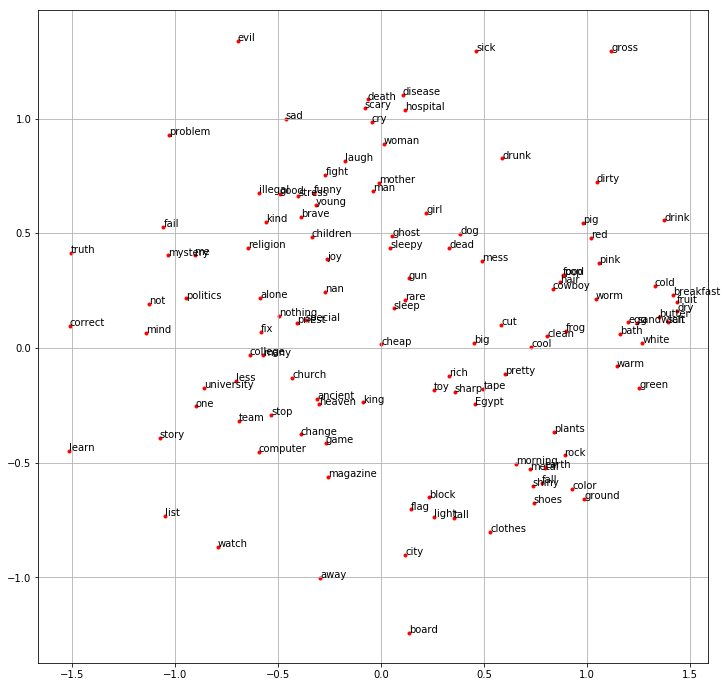

In [35]:
# Does plotting
max_words = 120

fig=plt.figure(figsize=(12, 12), facecolor='w', edgecolor='k')

plt.scatter(result[:max_words, 0], result[:max_words, 1],marker = '.',color='r')
for i, word in enumerate(words[:max_words]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.grid(True)


# t-SNE
Here's a t-SNE visualization of all the words...

[under construction...]

/home/ansonl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


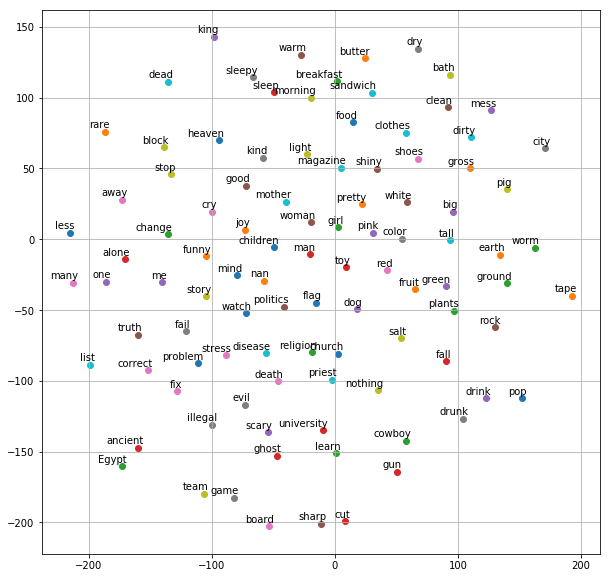

In [34]:
from sklearn.manifold import TSNE
def tsne_plot(model, max_words=100):
    '''
    Inputs:
    model - output of the Word2Vec model
    max_words - number of words to plot so that it doesn't plot the entire vocabulary
    '''
    labels, tokens = [], []

    counter = 0
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        counter += 1
        if counter == max_words:
            break
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x,y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.grid(True)
    plt.show()
    
tsne_plot(model)

Let's see what are the most common word associations for a given word. The following code will create a word cloud for a randomly selected word. Note that the size of the word here indicates the cosine similarity, which is different from frequency.

Remember, the "similarity" here indicates the association between words (i.e. cue and response). It's not [necessarily] a measure of semantic similarity!

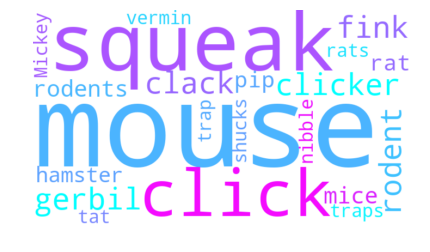

In [174]:
from wordcloud import WordCloud
import random

def wordcloud_plot(input_word, input_model):
    # Finds the most similar words
    similar_words = input_model.wv.most_similar(input_word, topn=20) 

    # Creates a dictionary to store words and similarities.
    d={input_word: 1} 
    for x in similar_words:
        d[x[0]] = x[1]

    # Creates the wordcloud
    wordcloud = WordCloud(width=700, height=400, margin=0,
                          colormap="cool",
                          background_color="white")
    wordcloud.generate_from_frequencies(frequencies=d)

    plt.figure(figsize=(7, 4)) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

# Randomly selects a word and plots the wordcloud
wordcloud_plot(random.choice(vocabulary), model)

# Gender differences in word associations

Male


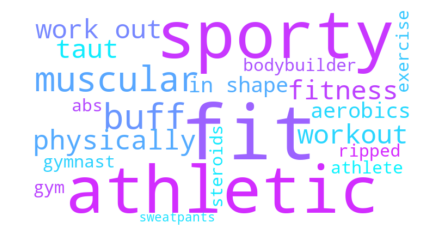

Female


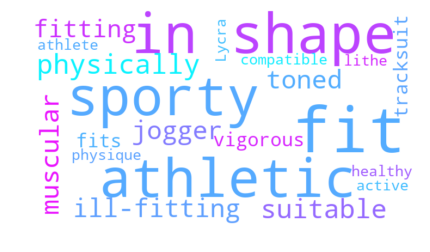

In [124]:
# Randomly selects a word and plots the wordclouds corresponding to the the male and female subset models
word_choice = random.choice(vocabulary)

print('Male')
wordcloud_plot(word_choice, model_m)
print('Female')
wordcloud_plot(word_choice, model_f)

Here's another set of word clouds that show the male-only, female-only, and shared associations for a given word.

Word: family


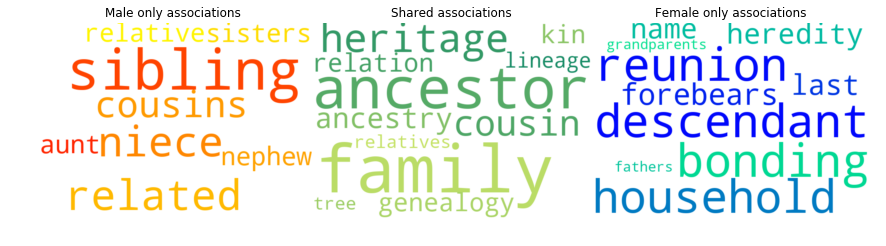

In [172]:
# Plots word clouds of overlaps and differences for male and female subsets for a given word
def wordcloud_different(input_word, input_model1, input_model2):
    # Finds the most similar words
    similar_words1 = input_model1.wv.most_similar(input_word, topn=20) 
    similar_words2 = input_model2.wv.most_similar(input_word, topn=20) 
    
    # Finds intersection and union
    words1 = [x[0] for x in similar_words1]
    words2 = [x[0] for x in similar_words2]
    
    words1_set = set(words1)
    words2_set = set(words2)
    
    words_intersection = list(words1_set.intersection(words2_set))
    words_union = words1_set.union(words2_set)
    words1_exclusive = list(words_union - words2_set)
    words2_exclusive = list(words_union - words1_set)
    
    words1_exclusive_str = ''
    words2_exclusive_str = ''
    words_intersection_str = input_word+' '
    
    for x in words1_exclusive:
        words1_exclusive_str += x+' '
        
    for x in words2_exclusive:
        words2_exclusive_str += x+' '
        
    for x in words_intersection:
        words_intersection_str += x+' '

    # Creates word clouds
    wordcloud_words1_exclusive = WordCloud(width=700, height=500, margin=0,
                          colormap="autumn",
                          background_color="white")
    wordcloud_words1_exclusive.generate(words1_exclusive_str)
    
    wordcloud_words2_exclusive = WordCloud(width=700, height=500, margin=0,
                          colormap="winter",
                          background_color="white")
    wordcloud_words2_exclusive.generate(words2_exclusive_str)
    
    wordcloud_intersection = WordCloud(width=700, height=500, margin=0,
                          colormap="summer",
                          background_color="white")
    wordcloud_intersection.generate(words_intersection_str)
    
    plt.figure(figsize=(15, 10)) 
    
    plt.subplot(131, frameon=False)
    plt.imshow(wordcloud_words1_exclusive, interpolation="bilinear")
    plt.axis("off")
    plt.title('Male only associations')
    
    plt.subplot(132, frameon=False)
    plt.imshow(wordcloud_intersection, interpolation="bilinear")
    plt.axis("off")
    plt.title('Shared associations')
    
    plt.subplot(133, frameon=False)
    plt.imshow(wordcloud_words2_exclusive, interpolation="bilinear")
    plt.title('Female only associations')
    
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.subplots_adjust(wspace=0, hspace=0.5)
    plt.show()

word_choice = 'family'
print('Word:',word_choice)
wordcloud_different(word_choice, model_m, model_f)
